<a href="https://colab.research.google.com/github/Audrey0109/Seoul_Bike/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling

In [ ]:
# We first import all the libraries that we will need
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import datetime as dt
#import calmap

# MACHINE LEARNING
import sklearn as sk
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier




In [ ]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv", encoding="latin1")

In [ ]:
df=df.rename(columns = {'Temperature(°C)': 'Temp', 'Rented Bike Count':'Bike_Count','Humidity(%)': 'Hum',
                     'Wind speed (m/s)':'Wind','Visibility (10m)':'Vis','Dew point temperature(°C)':'Dew',
                    'Solar Radiation (MJ/m2)':'Solar','Rainfall(mm)':'Rain','Snowfall (cm)':'Snow'}) 
df

,Date,Bike_Count,Hour,Temp,Hum,Wind,Vis,Dew,Solar,Rain,Snow,Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [ ]:
def part_of_the_day(hour):
    if(hour < 6):
        return "Night"
    elif (hour < 12):
        return "Morning"
    elif (hour < 18):
        return "Afternoon"
    else :
          return "Evening"

In [ ]:
# Function to get the number of a month
def number_month(month):
    if month == "January":
        return 1
    elif month == "February":
        return 2
    elif month == "March":
        return 3
    elif month == "April":
        return 4
    elif month == "May":
        return 5
    elif month == "June":
        return 6
    elif month == "July":
        return 7
    elif month == "August":
        return 8
    elif month == "September":
        return 9
    elif month == "October":
        return 10
    elif month == "November":
        return 11
    else :
        return 12

In [ ]:
# We change the format of the "Date" column 
from datetime import datetime
df['Date'] =  pd.to_datetime(df['Date'], format='%d/%m/%Y')

# We create a column "Day" and "Month" (number of the month: 1 to 12)
df['Day_week'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df["Month"] = df["Month"].apply(lambda x : number_month(x))

# We create a new column in the dataframe to precise the part of the day
df["Part_of_the_day"] = df["Hour"].apply(lambda x : part_of_the_day(int(x)))

# We create a new column in the dataframe to precise if the day is a week-end day or not
df["Week_end_day"] = ["yes" if df.iloc[i]["Day_week"] in ("Saturday", "Sunday") else 'no' for i in range(len(df))]

# Binary values for the columns "Holiday" and "Functioning Day"
df['Holiday'] = [1 if x=='Holiday' else 0 for x in df['Holiday'] ]
df['Functioning Day'] = [1 if x=='Yes' else 0 for x in df['Functioning Day'] ]

# We convert categorical features into numerical values using the get_dummies function from pandas
dummies = ['Seasons','Day_week','Part_of_the_day','Week_end_day']
dummy_data= pd.get_dummies(df[dummies])
dummy_data.shape
df = pd.concat([df, dummy_data], axis = 1)
df.drop(dummies, axis=1, inplace=True)

# To avoid raising an error with the DateTime format, we convert this datatype column in numeric
df['Date'] = pd.to_numeric(pd.to_datetime(df['Date']))

df.head()

,Date,Bike_Count,Hour,Temp,Hum,Wind,Vis,Dew,Solar,Rain,Snow,Holiday,Functioning Day,Month,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Day_week_Friday,Day_week_Monday,Day_week_Saturday,Day_week_Sunday,Day_week_Thursday,Day_week_Tuesday,Day_week_Wednesday,Part_of_the_day_Afternoon,Part_of_the_day_Evening,Part_of_the_day_Morning,Part_of_the_day_Night,Week_end_day_no,Week_end_day_yes
0,1512086400000000000,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,12,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0
1,1512086400000000000,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,12,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0
2,1512086400000000000,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,12,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0
3,1512086400000000000,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,12,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0
4,1512086400000000000,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,1,12,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0


In [ ]:
#let's check if all the values are numeric 
df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

Date                         True
Bike_Count                   True
Hour                         True
Temp                         True
Hum                          True
Wind                         True
Vis                          True
Dew                          True
Solar                        True
Rain                         True
Snow                         True
Holiday                      True
Functioning Day              True
Month                        True
Seasons_Autumn               True
Seasons_Spring               True
Seasons_Summer               True
Seasons_Winter               True
Day_week_Friday              True
Day_week_Monday              True
Day_week_Saturday            True
Day_week_Sunday              True
Day_week_Thursday            True
Day_week_Tuesday             True
Day_week_Wednesday           True
Part_of_the_day_Afternoon    True
Part_of_the_day_Evening      True
Part_of_the_day_Morning      True
Part_of_the_day_Night        True
Week_end_day_n

### Split the data into a train and a test set

In [ ]:
x, y = df.loc[:,df.columns != 'Bike_Count'], df.loc[:,'Bike_Count']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 1)

### Scaling the data

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## Models 

### Linear Regression 

In [ ]:
linear_reg = LinearRegression().fit(x_train, y_train)
#print(linear_reg.coef_)

# Prediction
y_prediction_linear_reg = linear_reg.predict(x_test)

# Score
r2_linear_reg = r2_score(y_test, y_prediction_linear_reg)
MSE_linear_reg = mean_squared_error(y_test, y_prediction_linear_reg)
print("R2 =", r2_linear_reg)
print("Mean squared error =", MSE_linear_reg)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_linear_reg)))

R2 = 0.5955560366432335
Mean squared error = 165006.97209929497
Root mean squared error = 406.2105022021156


### Ridge Regression

#### Cross-Validation

In [ ]:
ridge_reg = linear_model.Ridge()
parameters = {"alpha" : np.logspace(-6, 6, 13)}

grid_search = GridSearchCV(estimator = ridge_reg,
                          param_grid = parameters,
                          cv = 10)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'alpha': 10.0}

#### Perform the model

In [ ]:
ridge_reg = linear_model.Ridge(alpha=10.0).fit(x_train, y_train)
#print(ridge_reg.coef_)
#print(ridge_reg.intercept_)

# Prediction
y_prediction_ridge_reg = ridge_reg.predict(x_test)

# Score
r2_ridge_reg = r2_score(y_test, y_prediction_ridge_reg)
MSE_ridge_reg = mean_squared_error(y_test, y_prediction_ridge_reg)
print("R2 =", r2_ridge_reg)
print("Mean squared error =", MSE_ridge_reg)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_ridge_reg)))

R2 = 0.595641667154553
Mean squared error = 164972.03615594484
Root mean squared error = 406.1674976606878


### Lasso Regression

#### Cross-Validation 

In [ ]:
lasso_reg = linear_model.Lasso()
parameters = {"alpha" : np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])}


grid_search = GridSearchCV(estimator = ridge_reg,
                          param_grid = parameters,
                          cv = 10)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'alpha': 1.0}

#### Perform the model

In [ ]:
lasso_reg = linear_model.Lasso(alpha=1.0).fit(x_train, y_train)
#print(lasso_reg.coef_)

# Prediction
y_prediction_lasso_reg = lasso_reg.predict(x_test)

# Score
r2_lasso_reg = r2_score(y_test, y_prediction_lasso_reg)
MSE_lasso_reg = mean_squared_error(y_test, y_prediction_lasso_reg)
print("R2 =", r2_lasso_reg)
print("Mean squared error =", MSE_lasso_reg)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_lasso_reg)))

R2 = 0.5958873652072563
Mean squared error = 164871.795095624
Root mean squared error = 406.04408023713876


### SVR

#### Cross-Validation

In [ ]:
svm_svr = SVR()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], 
              "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], 
              "gamma": ['scale', 'auto']}

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]


grid_search = GridSearchCV(estimator=svm_svr,
                           param_grid=parameters,
                           cv=10)

grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] C=50, gamma=scale, kernel=poly ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=50, gamma=scale, kernel=poly, score=0.596, total=   1.4s
[CV] C=50, gamma=scale, kernel=poly ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ...... C=50, gamma=scale, kernel=poly, score=0.613, total=   1.5s
[CV] C=50, gamma=scale, kernel=poly ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] ...... C=50, gamma=scale, kernel=poly, score=0.635, total=   1.5s
[CV] C=50, gamma=scale, kernel=poly ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


[CV] ...... C=50, gamma=scale, kernel=poly, score=0.655, total=   1.4s
[CV] C=50, gamma=scale, kernel=poly ..................................
[CV] ...... C=50, gamma=scale, kernel=poly, score=0.661, total=   1.5s
[CV] C=50, gamma=scale, kernel=poly ..................................
[CV] ...... C=50, gamma=scale, kernel=poly, score=0.489, total=   1.4s
[CV] C=50, gamma=scale, kernel=poly ..................................
[CV] ...... C=50, gamma=scale, kernel=poly, score=0.610, total=   1.4s
[CV] C=50, gamma=scale, kernel=poly ..................................
[CV] ...... C=50, gamma=scale, kernel=poly, score=0.617, total=   1.4s
[CV] C=50, gamma=scale, kernel=poly ..................................
[CV] ...... C=50, gamma=scale, kernel=poly, score=0.597, total=   1.5s
[CV] C=50, gamma=scale, kernel=poly ..................................
[CV] ...... C=50, gamma=scale, kernel=poly, score=0.634, total=   1.4s
[CV] C=50, gamma=scale, kernel=rbf ...................................
[CV] .

[CV] ...... C=25, gamma=scale, kernel=poly, score=0.541, total=   1.6s
[CV] C=25, gamma=scale, kernel=poly ..................................
[CV] ...... C=25, gamma=scale, kernel=poly, score=0.561, total=   1.5s
[CV] C=25, gamma=scale, kernel=poly ..................................
[CV] ...... C=25, gamma=scale, kernel=poly, score=0.579, total=   1.5s
[CV] C=25, gamma=scale, kernel=poly ..................................
[CV] ...... C=25, gamma=scale, kernel=poly, score=0.607, total=   1.5s
[CV] C=25, gamma=scale, kernel=poly ..................................
[CV] ...... C=25, gamma=scale, kernel=poly, score=0.498, total=   1.6s
[CV] C=25, gamma=scale, kernel=poly ..................................
[CV] ...... C=25, gamma=scale, kernel=poly, score=0.546, total=   1.7s
[CV] C=25, gamma=scale, kernel=poly ..................................
[CV] ...... C=25, gamma=scale, kernel=poly, score=0.558, total=   1.5s
[CV] C=25, gamma=scale, kernel=poly ..................................
[CV] .

[CV] .... C=25, gamma=auto, kernel=sigmoid, score=0.331, total=   2.0s
[CV] C=10, gamma=scale, kernel=poly ..................................
[CV] ...... C=10, gamma=scale, kernel=poly, score=0.416, total=   1.6s
[CV] C=10, gamma=scale, kernel=poly ..................................
[CV] ...... C=10, gamma=scale, kernel=poly, score=0.418, total=   1.6s
[CV] C=10, gamma=scale, kernel=poly ..................................
[CV] ...... C=10, gamma=scale, kernel=poly, score=0.434, total=   1.6s
[CV] C=10, gamma=scale, kernel=poly ..................................
[CV] ...... C=10, gamma=scale, kernel=poly, score=0.448, total=   1.5s
[CV] C=10, gamma=scale, kernel=poly ..................................
[CV] ...... C=10, gamma=scale, kernel=poly, score=0.503, total=   1.6s
[CV] C=10, gamma=scale, kernel=poly ..................................
[CV] ...... C=10, gamma=scale, kernel=poly, score=0.390, total=   1.4s
[CV] C=10, gamma=scale, kernel=poly ..................................
[CV] .

[CV] .... C=10, gamma=auto, kernel=sigmoid, score=0.460, total=   1.8s
[CV] C=10, gamma=auto, kernel=sigmoid ................................
[CV] .... C=10, gamma=auto, kernel=sigmoid, score=0.440, total=   1.8s
[CV] C=10, gamma=auto, kernel=sigmoid ................................
[CV] .... C=10, gamma=auto, kernel=sigmoid, score=0.441, total=   1.7s
[CV] C=5, gamma=scale, kernel=poly ...................................
[CV] ....... C=5, gamma=scale, kernel=poly, score=0.297, total=   1.5s
[CV] C=5, gamma=scale, kernel=poly ...................................
[CV] ....... C=5, gamma=scale, kernel=poly, score=0.301, total=   1.4s
[CV] C=5, gamma=scale, kernel=poly ...................................
[CV] ....... C=5, gamma=scale, kernel=poly, score=0.314, total=   1.4s
[CV] C=5, gamma=scale, kernel=poly ...................................
[CV] ....... C=5, gamma=scale, kernel=poly, score=0.321, total=   1.4s
[CV] C=5, gamma=scale, kernel=poly ...................................
[CV] .

[CV] ..... C=5, gamma=auto, kernel=sigmoid, score=0.410, total=   1.9s
[CV] C=5, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=5, gamma=auto, kernel=sigmoid, score=0.430, total=   1.8s
[CV] C=5, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=5, gamma=auto, kernel=sigmoid, score=0.450, total=   1.8s
[CV] C=5, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=5, gamma=auto, kernel=sigmoid, score=0.426, total=   1.8s
[CV] C=5, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=5, gamma=auto, kernel=sigmoid, score=0.431, total=   1.8s
[CV] C=1.0, gamma=scale, kernel=poly .................................
[CV] ..... C=1.0, gamma=scale, kernel=poly, score=0.039, total=   1.4s
[CV] C=1.0, gamma=scale, kernel=poly .................................
[CV] ..... C=1.0, gamma=scale, kernel=poly, score=0.043, total=   1.5s
[CV] C=1.0, gamma=scale, kernel=poly .................................
[CV] .

[CV] ... C=1.0, gamma=auto, kernel=sigmoid, score=0.283, total=   1.8s
[CV] C=1.0, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=1.0, gamma=auto, kernel=sigmoid, score=0.335, total=   1.8s
[CV] C=1.0, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=1.0, gamma=auto, kernel=sigmoid, score=0.254, total=   1.9s
[CV] C=1.0, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=1.0, gamma=auto, kernel=sigmoid, score=0.285, total=   1.8s
[CV] C=1.0, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=1.0, gamma=auto, kernel=sigmoid, score=0.295, total=   1.7s
[CV] C=1.0, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=1.0, gamma=auto, kernel=sigmoid, score=0.258, total=   1.8s
[CV] C=1.0, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=1.0, gamma=auto, kernel=sigmoid, score=0.278, total=   2.0s
[CV] C=0.1, gamma=scale, kernel=poly .................................
[CV] .

[CV] .. C=0.1, gamma=auto, kernel=sigmoid, score=-0.031, total=   1.8s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] .. C=0.1, gamma=auto, kernel=sigmoid, score=-0.026, total=   2.0s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] .. C=0.1, gamma=auto, kernel=sigmoid, score=-0.042, total=   1.9s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=0.1, gamma=auto, kernel=sigmoid, score=0.008, total=   2.0s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] .. C=0.1, gamma=auto, kernel=sigmoid, score=-0.052, total=   1.9s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] .. C=0.1, gamma=auto, kernel=sigmoid, score=-0.007, total=   2.1s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] ... C=0.1, gamma=auto, kernel=sigmoid, score=0.006, total=   2.0s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] .

[CV] ..... C=0.01, gamma=auto, kernel=rbf, score=-0.127, total=   1.7s
[CV] C=0.01, gamma=auto, kernel=sigmoid ..............................
[CV] . C=0.01, gamma=auto, kernel=sigmoid, score=-0.110, total=   1.9s
[CV] C=0.01, gamma=auto, kernel=sigmoid ..............................
[CV] . C=0.01, gamma=auto, kernel=sigmoid, score=-0.097, total=   1.8s
[CV] C=0.01, gamma=auto, kernel=sigmoid ..............................
[CV] . C=0.01, gamma=auto, kernel=sigmoid, score=-0.094, total=   1.9s
[CV] C=0.01, gamma=auto, kernel=sigmoid ..............................
[CV] . C=0.01, gamma=auto, kernel=sigmoid, score=-0.114, total=   1.9s
[CV] C=0.01, gamma=auto, kernel=sigmoid ..............................
[CV] . C=0.01, gamma=auto, kernel=sigmoid, score=-0.068, total=   2.0s
[CV] C=0.01, gamma=auto, kernel=sigmoid ..............................
[CV] . C=0.01, gamma=auto, kernel=sigmoid, score=-0.119, total=   2.0s
[CV] C=0.01, gamma=auto, kernel=sigmoid ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 11.9min finished


{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

#### Perform the model

In [ ]:
svm_svr = SVR(C=50, gamma='scale', kernel='rbf').fit(x_train, y_train)

# Prediction
y_prediction_svm_svr = svm_svr.predict(x_test)

# Score
r2_svm_svr = r2_score(y_test, y_prediction_svm_svr)
MSE_svm_svr = mean_squared_error(y_test, y_prediction_svm_svr)
print("R2 =", r2_svm_svr)
print("Mean squared error =", MSE_svm_svr)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_svm_svr)))

R2 = 0.7512580906011369
Mean squared error = 101482.90745508758
Root mean squared error = 318.56382006607026


### KNN

#### Cross-Validation

In [ ]:
knn_reg = KNeighborsRegressor()
parameters = {"n_neighbors" : range(3, 25), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}


grid_search = GridSearchCV(estimator = knn_reg,
                          param_grid = parameters,
                          cv = 10)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

#### Perform the model

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance').fit(x_train, y_train)

# Prediction
y_prediction_knn_reg = knn_reg.predict(x_test)

# Score
r2_knn_reg = r2_score(y_test, y_prediction_knn_reg)
MSE_knn_reg = mean_squared_error(y_test, y_prediction_knn_reg)
print("R2 =", r2_knn_reg)
print("Mean squared error =", MSE_knn_reg)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_knn_reg)))

R2 = 0.8195184097995944
Mean squared error = 73633.73771600757
Root mean squared error = 271.3553716365452


### Decision Tree Regression

#### Cross-Validation

In [ ]:
decision_tree_reg = DecisionTreeRegressor()
parameters = {"max_depth" : np.array([5, 10, 20, 50, 100, 200, 500])}


grid_search = GridSearchCV(estimator = decision_tree_reg,
                          param_grid = parameters,
                          cv = 10)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 50}

#### Perform the model

In [ ]:
tree_reg = DecisionTreeRegressor(max_depth=10).fit(x_train, y_train)

# Prediction
y_prediction_tree_reg = tree_reg.predict(x_test)

# Score
r2_tree_reg = r2_score(y_test, y_prediction_tree_reg)
MSE_tree_reg = mean_squared_error(y_test, y_prediction_tree_reg)
print("R2 =", r2_tree_reg)
print("Mean squared error =", MSE_tree_reg)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_tree_reg)))

R2 = 0.8407342061743907
Mean squared error = 64978.01618804832
Root mean squared error = 254.90785823126035


### Random Forest 

#### Cross-Validation

In [ ]:
rf_reg = RandomForestRegressor()

parameters = {'n_estimators': [10, 25], 'max_features': [5, 10, 15], 
 'max_depth': [10, 50, 100], 'bootstrap': [True, False]}


grid_search = GridSearchCV(estimator = rf_reg,
                          param_grid = parameters, 
                          cv = 10)

grid_search.fit(x_train, y_train)
grid_search.best_params_

KeyboardInterrupt: ignored

#### Perform the model

In [ ]:
rf_reg = RandomForestRegressor(bootstrap=False, max_depth=100, max_features=15, n_estimators=25).fit(x_train, y_train)

# Prediction
y_prediction_rf_reg = rf_reg.predict(x_test)

# Score
r2_rf_reg = r2_score(y_test, y_prediction_rf_reg)
MSE_rf_reg = mean_squared_error(y_test, y_prediction_rf_reg)
print("R2 =", r2_rf_reg)
print("Mean squared error =", MSE_rf_reg)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_rf_reg)))

R2 = 0.9328410787210777
Mean squared error = 27399.816176547905
Root mean squared error = 165.52889831249377


### Gradient Boosting Regressor

#### Cross-Validation

In [ ]:
grad_boosting_reg = GradientBoostingRegressor()
parameters = {'n_estimators':[10,100,500],
              'learning_rate':[.001,0.01,.1],
              'max_depth':[1,2,4],
              'subsample':[.5,.75,1]}

grid_search = GridSearchCV(estimator=grad_boosting_reg,
                           param_grid=parameters,
                           cv=5)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.75}

#### Perform the model

In [ ]:
grad_boosting_reg = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, n_estimators=500, subsample=0.75).fit(x_train, y_train)

# Prediction
y_prediction_grad_boosting_reg = grad_boosting_reg.predict(x_test)

# Score
r2_grad_boosting_reg = r2_score(y_test, y_prediction_grad_boosting_reg)
MSE_grad_boosting_reg = mean_squared_error(y_test, y_prediction_grad_boosting_reg)
print("R2 =", r2_grad_boosting_reg)
print("Mean squared error =", MSE_grad_boosting_reg)
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_grad_boosting_reg)))

R2 = 0.93864852815214
Mean squared error = 25030.465331783176
Root mean squared error = 158.2101935141449


### Neural Network Regression

In [ ]:
neural_network_reg = MLPRegressor(random_state=1, max_iter=5000).fit(x_train, y_train)

# Prediction
y_prediction_neural_network_reg = neural_network_reg.predict(x_test)

# Score
r2 = r2_score(y_test, y_prediction_neural_network_reg)
print("R2 =", r2)
print("Mean squared error =", mean_squared_error(y_test, y_prediction_neural_network_reg))
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_neural_network_reg)))

R2 = 0.8863461250694694
Mean squared error = 46369.04854256881
Root mean squared error = 215.33473603338783


In [ ]:
# with hidden_layer_sizes=(64,64,64), activation="relu"

neural_network_reg = MLPRegressor(random_state=1, max_iter=5000, hidden_layer_sizes=(64,64,64), activation="relu").fit(x_train, y_train)

# Prediction
y_prediction_neural_network_reg = neural_network_reg.predict(x_test)

# Score
r2 = r2_score(y_test, y_prediction_neural_network_reg)

print("R2 =", r2)
print("Mean squared error =", mean_squared_error(y_test, y_prediction_neural_network_reg))
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_neural_network_reg)))

R2 = 0.9173278550751389
Mean squared error = 33728.97495560359
Root mean squared error = 183.65449887112374


In [ ]:
# with hidden_layer_sizes=(64,64,64), activation="tanh"

neural_network_reg = MLPRegressor(random_state=1, max_iter=5000, hidden_layer_sizes=(64,64,64), activation="tanh").fit(x_train, y_train)

# Prediction
y_prediction_neural_network_reg = neural_network_reg.predict(x_test)

# Score
r2 = r2_score(y_test, y_prediction_neural_network_reg)

print("R2 =", r2)
print("Mean squared error =", mean_squared_error(y_test, y_prediction_neural_network_reg))
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_neural_network_reg)))

R2 = 0.9103900794028674
Mean squared error = 36559.48167718824
Root mean squared error = 191.20533903944272


In [ ]:
# with hidden_layer_sizes=(64,64,64), activation="logistic"

neural_network_reg = MLPRegressor(random_state=1, max_iter=5000, hidden_layer_sizes=(64,64,64), activation="logistic").fit(x_train, y_train)

# Prediction
y_prediction_neural_network_reg = neural_network_reg.predict(x_test)

# Score
r2 = r2_score(y_test, y_prediction_neural_network_reg)

print("R2 =", r2)
print("Mean squared error =", mean_squared_error(y_test, y_prediction_neural_network_reg))
print("Root mean squared error =", np.sqrt(mean_squared_error(y_test, y_prediction_neural_network_reg)))

R2 = 0.9096740811388817
Mean squared error = 36851.5980549135
Root mean squared error = 191.96770055119558


In [ ]:
à lancer -> prend loooooooongtemps

In [ ]:
neural_network_reg = MLPRegressor(random_state=1, max_iter=5000)
parameters = {'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (64, 64, 64)],
   'activation': ['relu'],
   'alpha': [0.0001, 0.05],
   'learning_rate': ['constant', 'adaptive'],
   'solver': ['adam']}


grid_search = GridSearchCV(estimator = neural_network_reg,
                          param_grid = parameters,
                          cv = 10)

grid_search.fit(x_train, y_train)
grid_search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_p

### Comparison of models

In [ ]:
MSE_models = [MSE_linear_reg, MSE_ridge_reg, MSE_lasso_reg, MSE_svm_svr, MSE_knn_reg, MSE_tree_reg, MSE_rf_reg, MSE_grad_boosting_reg]
names_models = ["Linear Regression", "Ridge Regression", "Lasso Regression", "SVR", "KNN", "Decision Tree Regression", "Random Forest", "Gradient Boosting Regressor"]
comparison = pd.DataFrame(MSE_models, index = names_models, columns = ["MSE"])
comparison.sort_values(by="MSE")

,MSE
Gradient Boosting Regressor,25030.465332
Random Forest,27399.816177
Decision Tree Regression,64978.016188
KNN,73633.737716
SVR,101482.907455
Lasso Regression,164871.795096
Ridge Regression,164972.036156
Linear Regression,165006.972099


Text(0.5, 1.0, 'Comparison of model scores')

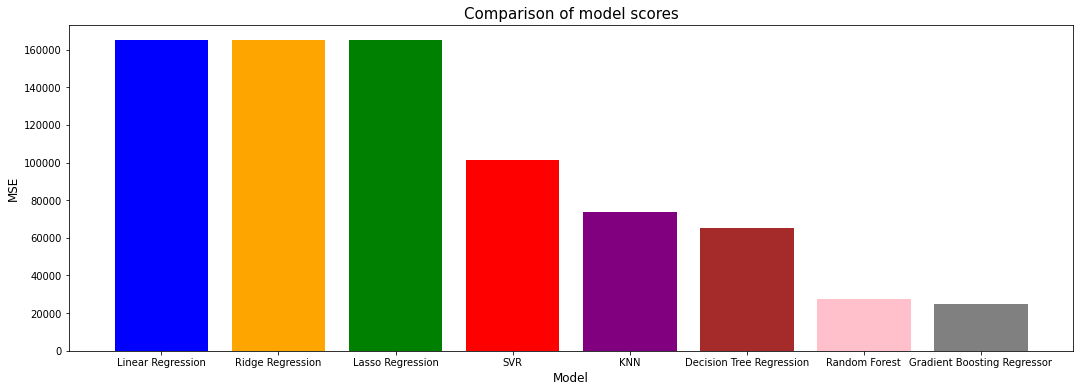

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
plt.bar(comparison.index, comparison["MSE"], color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
#We add the legends and title 
plt.xlabel("Model", fontsize= 12)
plt.ylabel("MSE", fontsize= 12)
plt.title("Comparison of model scores", fontsize= 15)

The best result is obtained with the gradient boosting regressor model.

# Flask Application

In [ ]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
#!ngrok authtoken 22jg9dgfJ2Vrf9hIs8I8fppLe24_4vre3wAhAg3T7F9ArM2Nr

In [7]:
!ngrok authtoken 231aDBrawch35gOZZoCIMc5Z8Lb_5nmGDpG4oTEUY1ich83VN

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [3]:
import pickle
from os import name
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template, redirect, url_for

In [26]:
from os import name 
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template, redirect, url_for

app = Flask(__name__, template_folder='/content', static_folder='/content/static')

run_with_ngrok(app)

@app.route('/')
def home():
    return render_template("index_accueil.html")

@app.route('/getpred',methods=['POST']) 
def getpred():
    return render_template("index_accueil.html", output="ok")

app.run()

if __name__ == "__main__":
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://3144-104-196-208-105.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [31/Dec/2021 00:23:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Dec/2021 00:23:41] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [31/Dec/2021 00:23:42] "GET /favicon.ico HTTP/1.1" 404 -


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


In [ ]:
app = Flask(__name__, template_folder='/content', static_folder='/content/static')

run_with_ngrok(app)

model_RF_all = pickle.load(open('/content/model_RF_all.pkl', 'rb'))
model_RF_bin = pickle.load(open('/content/model_RF_bin.pkl', 'rb'))


@app.route('/')
def home():
    return render_template("index_accueil.html")

@app.route('/Binary_prediction',methods=['POST'])
def Binary_prediction(): 
  return render_template("binary_classification.html")

@app.route('/All_classes_prediction',methods=['POST'])
def All_classes_prediction(): 
  return render_template("all_classes.html")

@app.route('/get_binary_prediction',methods=['POST'])
def get_binary_prediction():    

    input = [x for x in request.form.values()]
    input.append("")

    x = Create_data_for_prediction(input)

    prediction = model_RF_bin.predict(x)

    return render_template("binary_classification.html", output='Predicted obesity level category : {}'.format(prediction))

@app.route('/get_all_classes_prediction',methods=['POST'])
def get_all_classes_prediction():    

    input = [x for x in request.form.values()]
    input.append("")

    x = Create_data_for_prediction(input)

    prediction = model_RF_all.predict(x)

    return render_template("all_classes_result.html", output='Predicted obesity level category : {}'.format(prediction))

app.run()


if __name__ == "__main__":
    app.run()